In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import configs
import os
from scipy.stats import sem
import matplotlib.cm as cm

In [2]:
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
engram_dir = '/mnt/smb/locker/aronov-locker/Ching/rl/'

# Helper functions

In [4]:
def plot(
    df, plot_key, plot_ep,
    fnames=None, figname=None, fname_labels=None,
    smooth_line=True, smooth_n=5, smooth_plot=True, colors=None,
    legend_title=None, ylim=None, plot_title=None):
    
    fig, ax = plt.subplots()
    zs = np.sort(np.unique(df['z']))
    episode = np.sort(np.unique(df['episode']))
    if fnames is None:
        fnames = np.unique(df['model'])
    for fname_idx, fname in enumerate(fnames):
        line = []
        shading_lower = []
        shading_upper = []
        for z in zs:
            means = []
            sems = []
            df_subset = df[(df['model']==fname) & (df['z']==z)]
            for ep in episode:
                vals = df_subset[df_subset['episode']==ep]
                vals = vals[plot_key]
                means.append(np.mean(vals))
                sems.append(sem(vals))
            means = np.array(means)
            sems = np.array(sems)
            mean_lowerbound = means - sems
            mean_upperbound = means + sems
            if smooth_line:
                means = smooth(episode, means, smooth_n)
                mean_lowerbound = smooth(episode, mean_lowerbound)
                mean_upperbound = smooth(episode, mean_upperbound)
            line.append(means[plot_ep])
            shading_lower.append(mean_lowerbound[plot_ep])
            shading_upper.append(mean_upperbound[plot_ep])
        if smooth_plot:
            _line = smooth(zs, line, 2)
            _shading_lower = smooth(zs, shading_lower, 2)
            _shading_upper = smooth(zs, shading_upper, 2)
            _line[0] = line[0]; _line[-1] = line[-1]
            _shading_lower[0] = shading_lower[0]
            _shading_lower[-1] = shading_lower[-1]
            _shading_upper[0] = shading_upper[0]
            _shading_upper[-1] = shading_upper[-1]
            line = _line; shading_lower = _shading_lower;
            shading_uppper = _shading_upper
        x_axis = zs
        if colors is not None:
            color = colors[fname_idx]
        else:
            color = None
        if fname_labels != None:
            label = fname_labels[fname_idx]
        else:
            label = fname
        ax.plot(x_axis, line, label=label, color=color, alpha=0.8)
        ax.fill_between(x_axis, shading_lower, shading_upper, alpha=0.2,color=color)
    plt.ylabel('Avg Episode Score')
    plt.xlabel('Latent Dimensions')
    #plt.xticks([0.75, 1, 1.25], ['$0.75$x', '$1$x', '$1.25$x'])
    #plt.legend(title=legend_title, fontsize=12, title_fontsize=12)
    if ylim != None:
        plt.ylim(ylim[0], ylim[1])
    if plot_title != None:
        plt.title(plot_title)
    plt.xlabel('Latent Size')
    plt.tight_layout()
    if figname != None:
        plt.savefig(figname+'.png', dpi=300)
    plt.show()

In [5]:
def smooth(xs, ys, n=3):
    return np.convolve(ys, np.ones(n)/n, mode='same')

In [6]:
def get_df(base, zs, net_yaml):
    data = {
        'valid_score': [], 'valid_steps':[], 'dims': [],
        'episode': [], 'model': [], 'z': [], 'step': [], 'file': []}
    for z in zs:
        task_dir = f'{base}_{net_yaml}_dim{z}'
        task_dir = f'{engram_dir}pickles/{task_dir}/'
        if not os.path.exists(task_dir): continue
        for pickle_file in os.listdir(task_dir):
            if not pickle_file.endswith('.p'): continue
            pickle_file = f'{task_dir}{pickle_file}'
            with open(pickle_file, 'rb') as f:
                results = pickle.load(f)
            valid_score = results['valid_score']
            valid_steps = results['valid_steps_per_ep']
            episode = results['episode']
            model = results['model']
            step = results['step']
            for i in range(len(valid_score)):
                if valid_score[i] == None: continue
                data['valid_score'].append(valid_score[i])
                data['valid_steps'].append(valid_steps[i])
                data['dims'].append(z)
                data['episode'].append(episode[i])
                _model = model[i].split(base+'_')[-1]
                data['model'].append(_model)
                data['z'].append(z)
                data['step'].append(step[i])
                data['file'].append(pickle_file)
    df = pd.DataFrame(data)
    return df

# Experiment

In [9]:
zs = np.arange(2, 17)

In [10]:
task_df = get_df('new_gridworld8x8', zs, 'dm')

In [11]:
np.unique(task_df['model'])

array(['entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro0',
       'g0_-2_entro-2', 'mf0'], dtype=object)

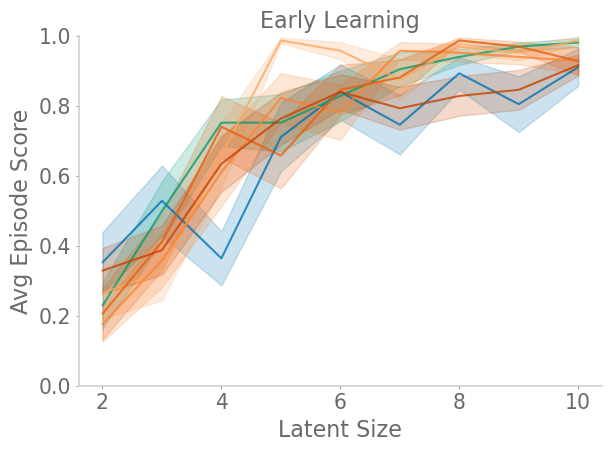

In [17]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score',
    100,
    smooth_line=False, smooth_n=20,
    fnames=['mf0', 'entro-1', 'g0_-2_entro-2', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning', ylim=(0,1)
    )

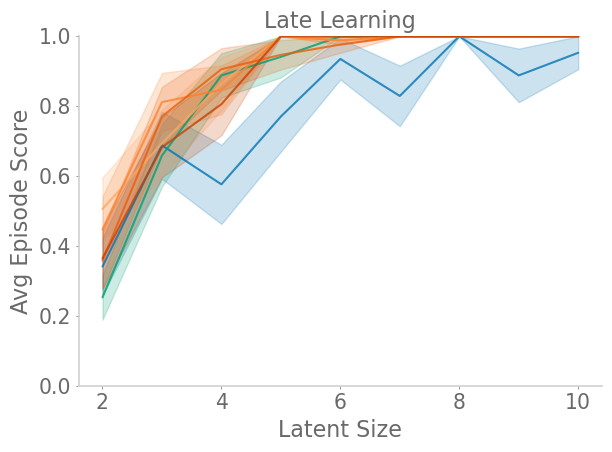

In [16]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score',
    350,
    smooth_line=False, smooth_n=20,
    fnames=['mf0', 'entro-1', 'g0_-2_entro-2', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    figname='gridworld6x6_taskA_late',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning', ylim=(0,1)
    )

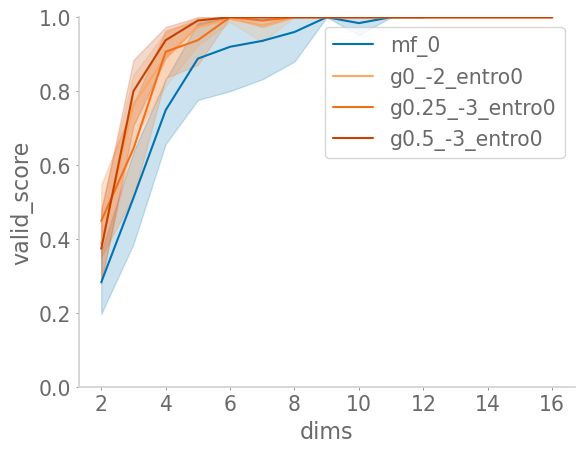

In [23]:
fig, ax = plt.subplots()
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 3, endpoint=True)
colors=['C0', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2])]
for idx, f in enumerate(['mf0', 'g0_-2_entro-2', 'g0.5_-3_entro-1', 'g0.5_-4_entro0']):
    dd = taskA_df[(taskA_df['episode']==250) & (taskA_df['model']==f)].copy()
    sns.lineplot(
        x='dims', y='valid_score', 
        data=dd, estimator='mean',
        ax=ax, label=f, color=colors[idx]
    )
plt.legend()
plt.ylim(0, 1.0)
plt.show()

# Experiment

In [18]:
zs = np.arange(2, 17)

In [19]:
task_df = get_df('fulltransfer_new_gridworld8x8', zs, 'dm')

In [20]:
np.unique(task_df['model'])

array(['entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro0',
       'g0_-2_entro-2', 'mf0'], dtype=object)

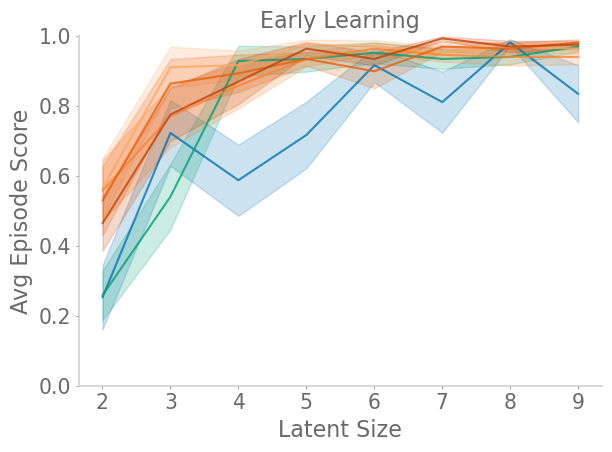

In [21]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score',
    100,
    smooth_line=False, smooth_n=20,
    fnames=['mf0', 'entro-1', 'g0_-2_entro-2', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    figname='gridworld6x6_taskA_early',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning', ylim=(0,1)
    )

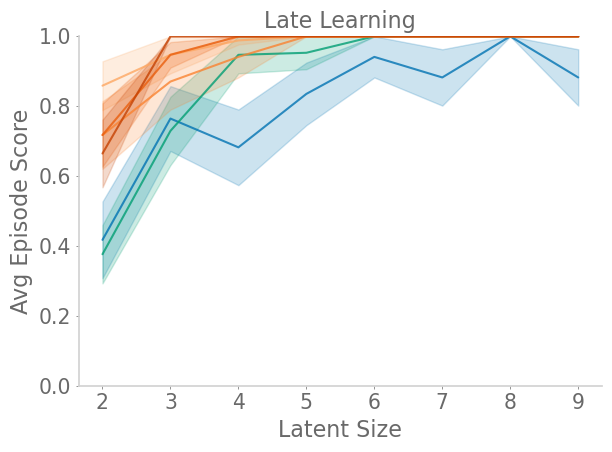

In [22]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    task_df, 'valid_score',
    350,
    smooth_line=False, smooth_n=20,
    fnames=['mf0', 'entro-1', 'g0_-2_entro-2', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    figname='gridworld6x6_taskA_late',
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning', ylim=(0,1)
    )

# Experiment

In [89]:
zs = np.arange(2, 20)

In [90]:
taskB_df = get_df('gridworld8x8_largeencoder', zs, 'dm_large_encoder')

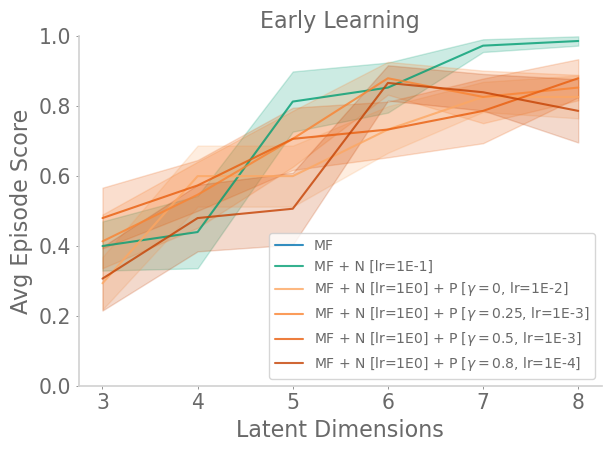

In [91]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    100,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

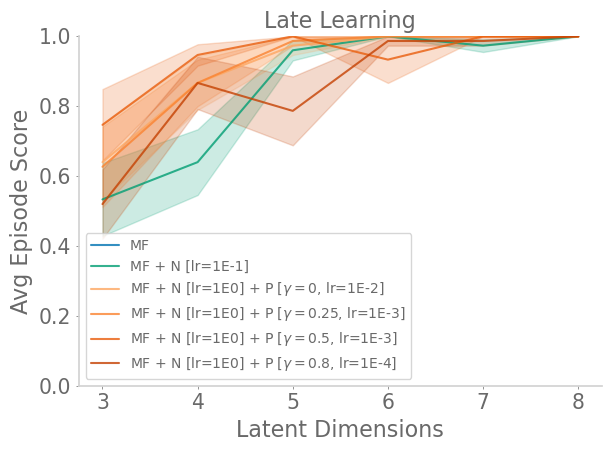

In [92]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

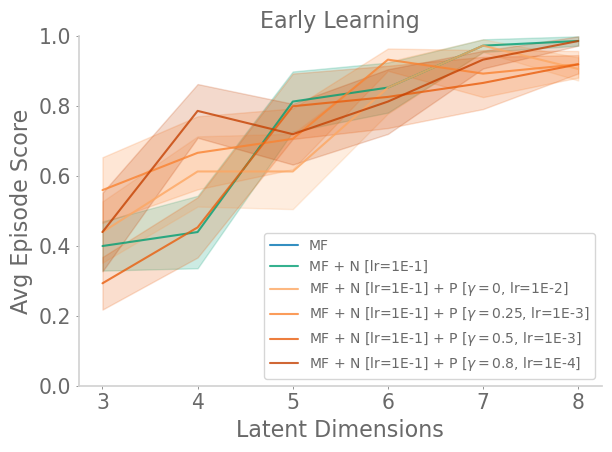

In [73]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    100,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

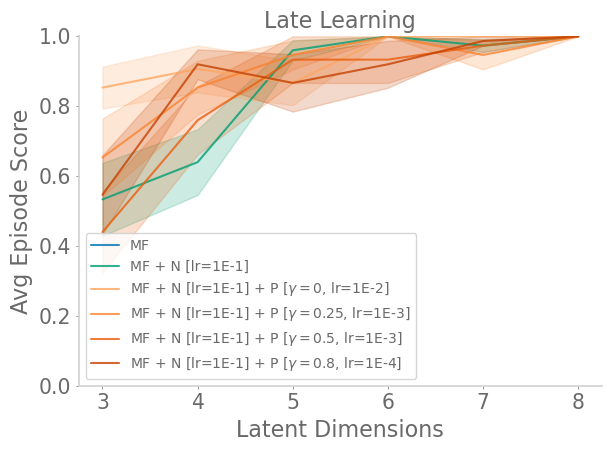

In [74]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

# Experiment

In [75]:
zs = np.arange(2, 20)

In [76]:
taskB_df = get_df('fulltransfer_gridworld8x8_largeencoder', zs, 'dm_large_encoder')

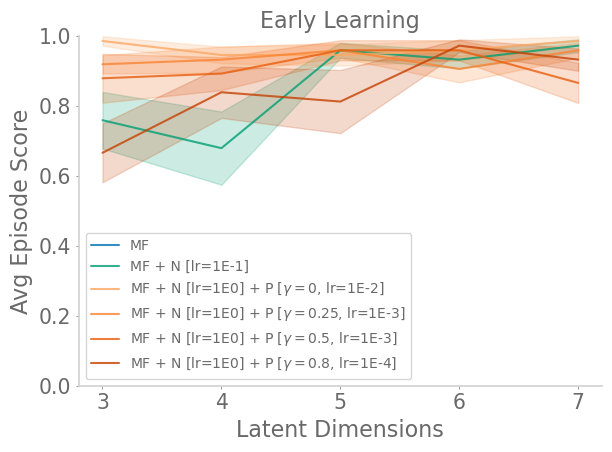

In [87]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    100,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

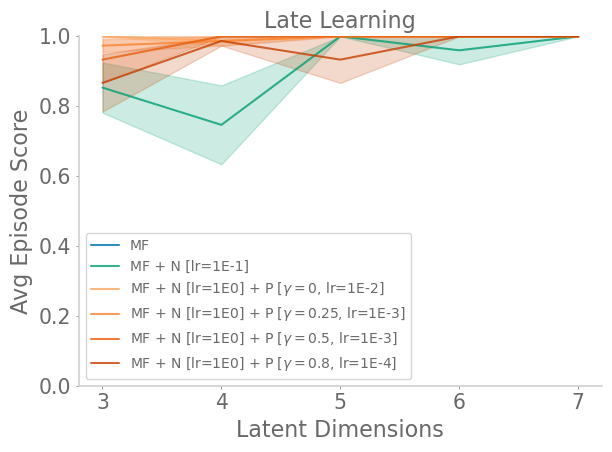

In [88]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

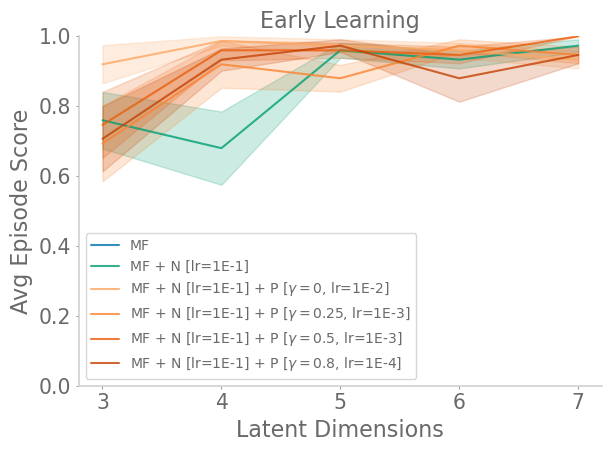

In [83]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    100,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

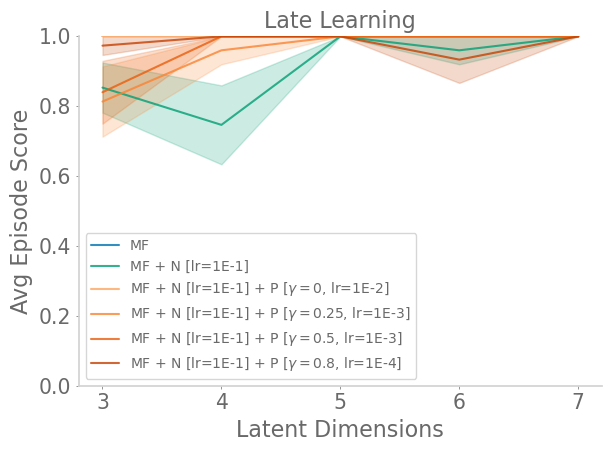

In [84]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

# Experiment

In [93]:
zs = np.arange(2, 20)

In [94]:
taskB_df = get_df('gridworld8x8_eps0.5', zs, 'dm')

In [96]:
np.unique(taskB_df['model'])

array(['entro-1', 'entro1', 'entro_0', 'g0.25_-3_entro-1',
       'g0.25_-3_entro0', 'g0.5_-3_entro-1', 'g0.5_-3_entro0',
       'g0.8_-4_entro-1', 'g0.8_-4_entro0', 'g0_-2_entro-1',
       'g0_-2_entro0'], dtype=object)

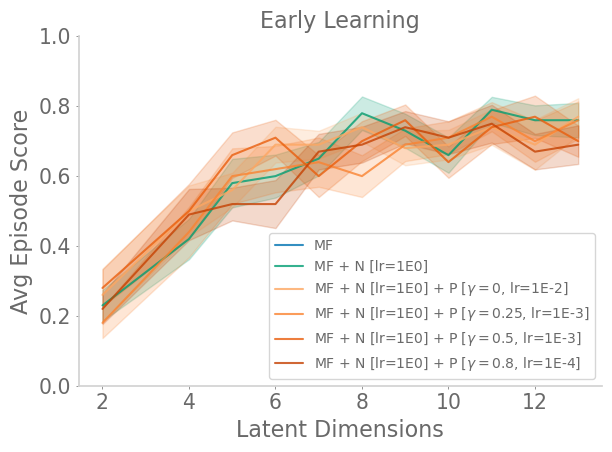

In [100]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    150,
    smooth_line=False,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

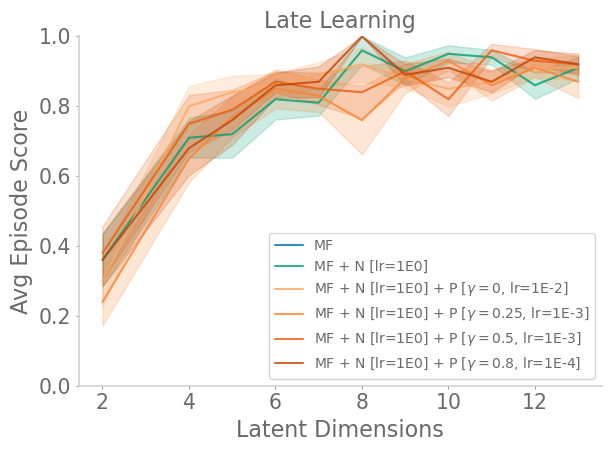

In [99]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    250,
    smooth_line=False,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

# Experiment

In [101]:
zs = np.arange(2, 20)

In [102]:
taskB_df = get_df('fulltransfer_gridworld8x8_eps0.5', zs, 'dm')

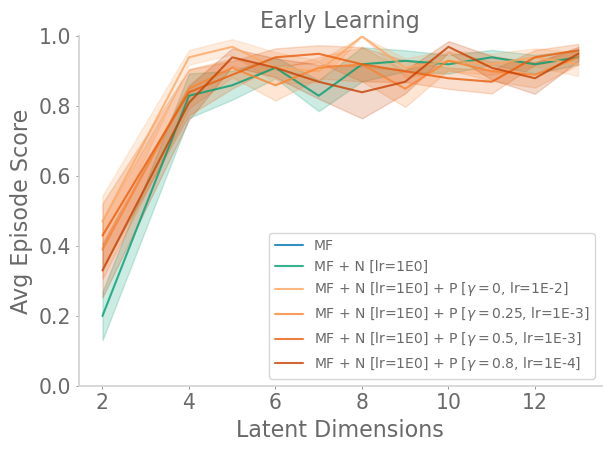

In [108]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    90,
    smooth_line=False,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

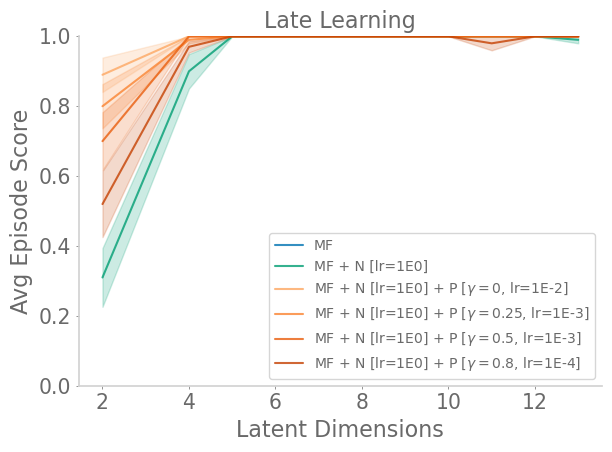

In [105]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro_0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

# Experiment

In [148]:
zs = np.arange(2, 20)

In [149]:
taskB_df = get_df('gridworld8x8', zs, 'dm_large_q')

/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/cf2794/.conda/envs/auxrl/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


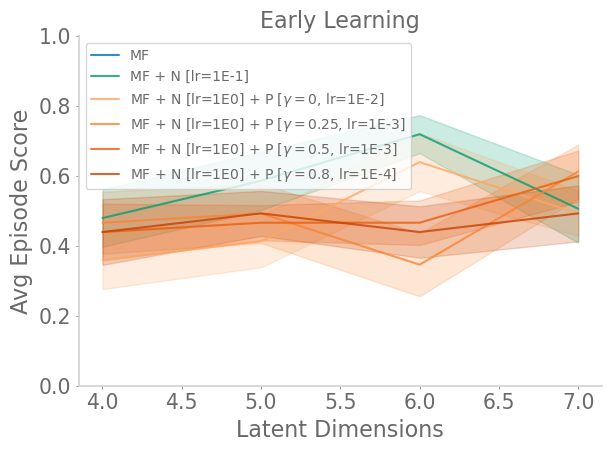

In [150]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    60,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

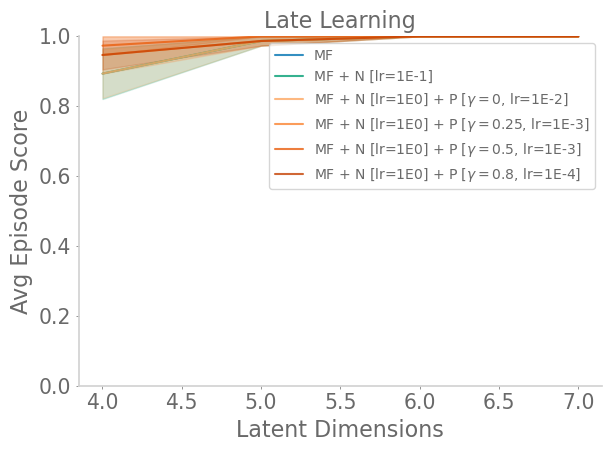

In [151]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

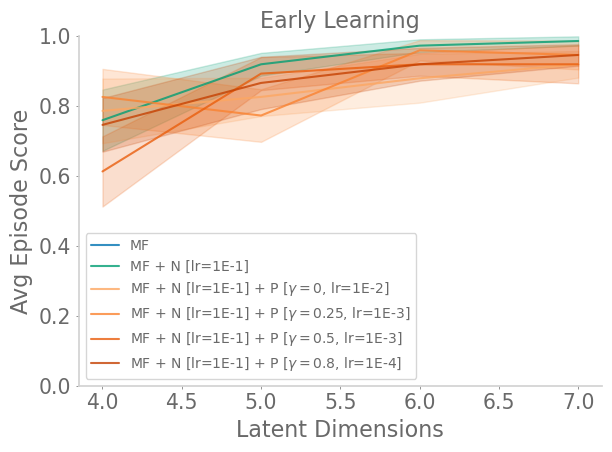

In [152]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    100,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

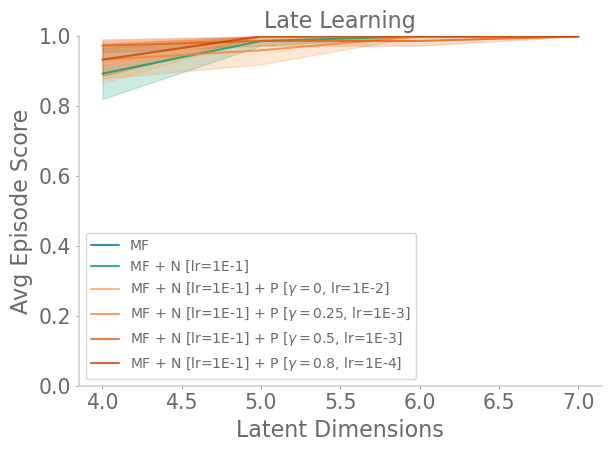

In [153]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

# Experiment

In [154]:
zs = np.arange(2, 20)

In [155]:
taskB_df = get_df('fulltransfer_gridworld8x8', zs, 'dm_large_q')

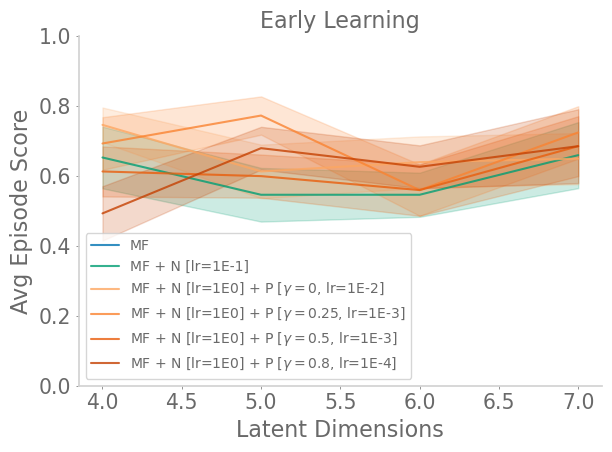

In [156]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    60,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

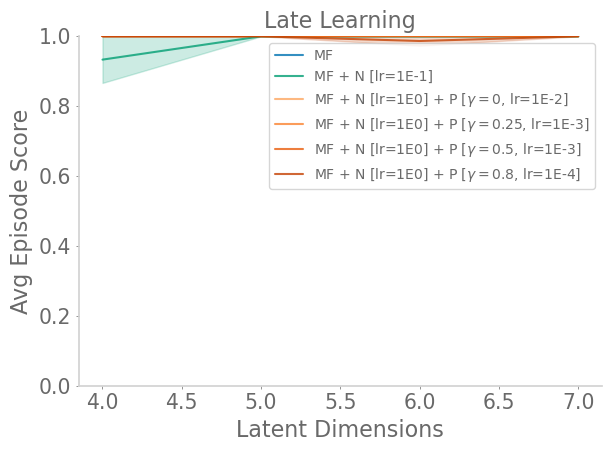

In [157]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

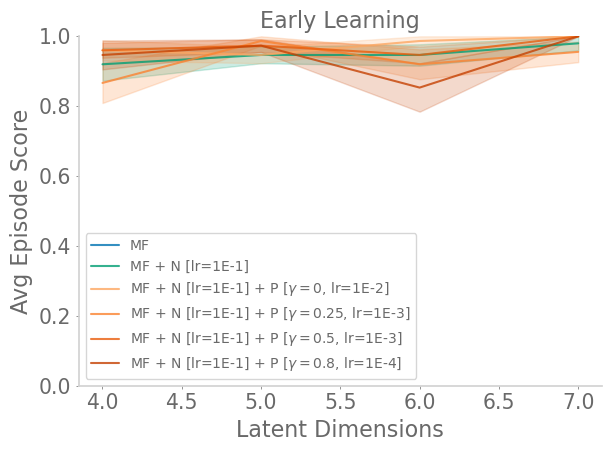

In [158]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    100,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

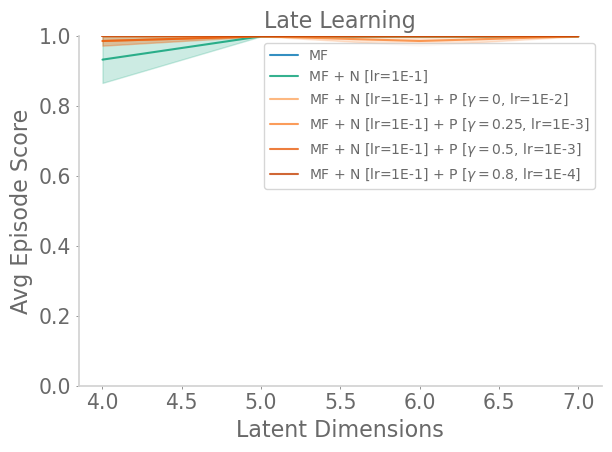

In [159]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    200,
    smooth_line=False,
    fnames=['mf', 'entro-1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    
    fname_labels=[
        'MF', 'MF + N [lr=1E-1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

# Experiment

In [41]:
zs = np.arange(2, 18)

In [42]:
taskA_df = get_df('gridworld8x8_shuffobs', zs, 'dm')

In [43]:
np.unique(taskA_df['model'])

array(['entro-1', 'entro0', 'entro1', 'g0.25_-3_entro-1',
       'g0.25_-3_entro0', 'g0.5_-3_entro-1', 'g0.5_-3_entro0',
       'g0.8_-4_entro-1', 'g0.8_-4_entro0', 'g0_-2_entro-1',
       'g0_-2_entro0', 'mf0', 'noQ_entro0', 'noQ_g0.5_-3_entro0',
       'noQ_g0_-2_entro0'], dtype=object)

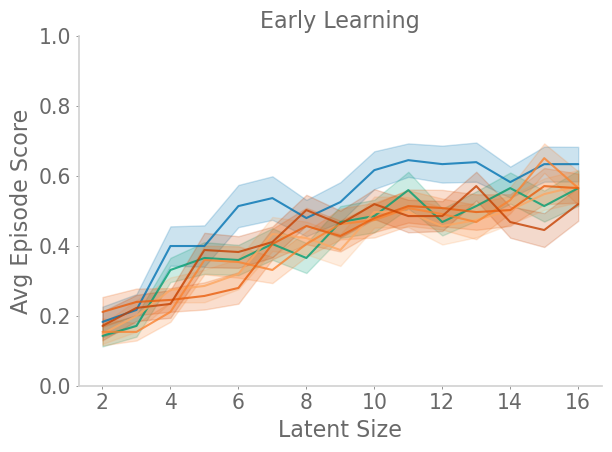

In [50]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskA_df, 'valid_score',
    120,
    smooth_line=False, smooth_n=10,
    fnames=['mf0', 'entro0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

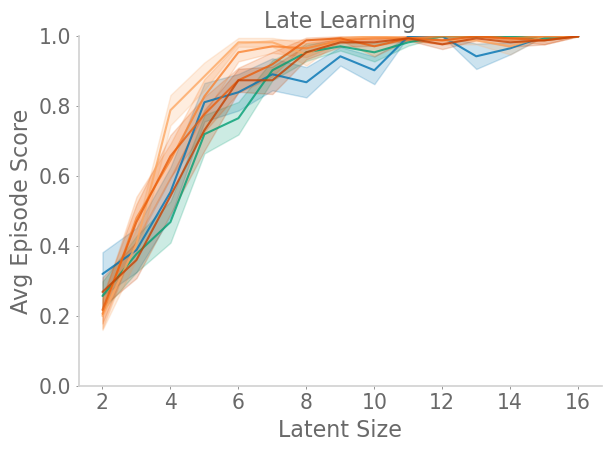

In [47]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskA_df, 'valid_score',
    300,
    smooth_line=False, smooth_n=10,
    fnames=['mf0', 'entro0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )

# Experiment

In [51]:
zs = np.arange(2, 18)

In [52]:
taskB_df = get_df('fulltransfer_gridworld8x8_shuffobs', zs, 'dm')

In [53]:
np.unique(taskB_df['model'])

array(['entro-1', 'entro0', 'entro1', 'g0.25_-3_entro-1',
       'g0.25_-3_entro0', 'g0.5_-3_entro-1', 'g0.5_-3_entro0',
       'g0.8_-4_entro-1', 'g0.8_-4_entro0', 'g0_-2_entro-1',
       'g0_-2_entro0', 'mf0'], dtype=object)

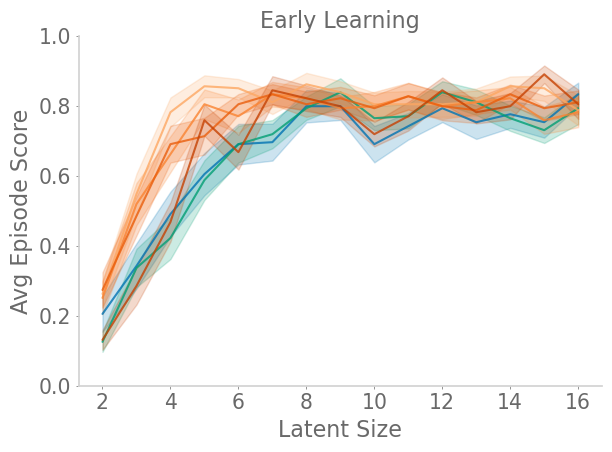

In [54]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    80,
    smooth_line=False, smooth_n=10,
    fnames=['mf0', 'entro0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

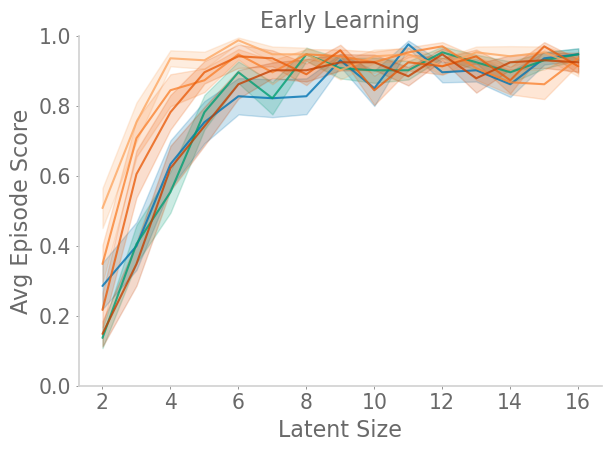

In [55]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    100,
    smooth_line=False, smooth_n=10,
    fnames=['mf0', 'entro1', 'g0_-2_entro-1', 'g0.25_-3_entro-1', 'g0.5_-3_entro-1', 'g0.8_-4_entro-1'],
    fname_labels=[
        'MF', 'MF + N [lr=1E1]',
        'MF + N [lr=1E-1] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E-1] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E-1] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Early Learning',
    ylim=[0,1]
    )

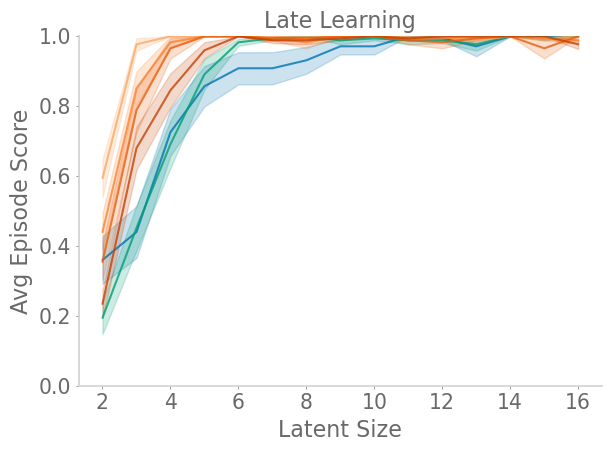

In [56]:
colors = cm.get_cmap('Oranges')
c_steps = np.linspace(0.4, 0.8, 4, endpoint=True)
plot(
    taskB_df, 'valid_score',
    300,
    smooth_line=False, smooth_n=10,
    fnames=['mf0', 'entro0', 'g0_-2_entro0', 'g0.25_-3_entro0', 'g0.5_-3_entro0', 'g0.8_-4_entro0'],
    fname_labels=[
        'MF', 'MF + N [lr=1E0]',
        'MF + N [lr=1E0] + P [$\gamma=0$, lr=1E-2]',
        'MF + N [lr=1E0] + P [$\gamma=0.25$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.5$, lr=1E-3]',
        'MF + N [lr=1E0] + P [$\gamma=0.8$, lr=1E-4]'],
    smooth_plot=False,
    colors=['C0', 'C2', colors(c_steps[0]), colors(c_steps[1]), colors(c_steps[2]), colors(c_steps[3])],
    plot_title='Late Learning',
    ylim=[0,1]
    )